# Building Machine Learning Systems That Don't Suck


References:

1. [Azure ML Studio Setup](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources?view=azureml-api-2)
2. [ML Studio Compute creation](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-compute-instance?view=azureml-api-2&tabs=python)
3. [ML Studio instance pricing](https://azure.microsoft.com/en-us/pricing/details/machine-learning/#pricing)
4. [AWS-Azure Compute comparison](https://www.justaftermidnight247.com/insights/aws-to-azure-instance-mapping-for-easy-comparison/)

Also see `azure_setup.md`. This file documents initial setup steps to get you up and running


## Section 1: Introduction and Initial Setup


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, basic information about HTTP sessions (URLs, headers, etc.)
# is logged at INFO level. Detailed DEBUG level logging, including request/response
# bodies and unredacted headers, can be enabled on a client with the `logging_enable` argument.
# See full SDK logging documentation with examples in the link below.
# https://learn.microsoft.com/en-us/azure/developer/python/sdk/azure-sdk-logging
#
# To prevent these from spoiling the output of this notebook cells,
# we can change the logging  level to ERROR instead.
logging.getLogger("azure.ai.ml").setLevel(logging.WARNING)


Let's now load the workspace configuration using the sdk and create a client for later use.


In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

client = MLClient.from_config(
    credential=DefaultAzureCredential(),
    file_path="../config.json",
)


Found the config file in: /Users/ayushgupta/Dev/DataspellProjects/ml.school/config.json


If you are running the pipeline in Local Mode on an ARM64 machine (for example, on Apple Silicon), you will need to use a custom Docker image to train and evaluate the model. Let's create a variable indicating if we are running on an ARM64 machine.


In [3]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
# architecture = !(uname -m)
#
# IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"


**NOTE**
Image builds using ACR tasks will soon be deprecated in favor of serverless computes. The transition should be seamless and automatic so no action is required on your part.
You will no longer need to set the imageBuildCompute property on your workspace for network isolation scenarios. All image builds by default will use serverless compute.
To learn more about serverless computes visit https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-serverless-compute?view=azureml-api-2&tabs=python.

Known Issues:
Serverless Computes require access to the workspace's default storage account.
If this storage account is accessible only through an allowed list of subnets, please set the Workspace.ServerlessComputeSubnet to one of the allowed subnets.
Please visit https://aka.ms/azureml/environment/secure-training-environments-with-virtual-networks for guidance on how to do this.

If you experience any other issues preventing you from building your image, you can temporarily opt out of using serverless computes by setting the image-build-compute property on your workspace to ACR-TASKS-FALLBACK
Please visit https://learn.microsoft.com/en-us/cli/azure/ml/workspace?view=azure-cli-latest#az-ml-workspace-update for guidance on how to do this.


In [3]:
from azure.ai.ml.entities import PipelineJob, PipelineJobSettings

# Create a PipelineJobSettings object
settings = PipelineJobSettings()

# Set the properties
settings.default_datastore = "penguins"
settings.default_compute = "serverless"
settings.continue_on_step_failure = False
settings.framework_version = "2.12"
settings.py_version = "py311"

# Create a PipelineJob
pipeline_job = PipelineJob(settings=settings)

# Now you can inspect the settings of the pipeline_job
print(pipeline_job.settings.default_datastore)
print(pipeline_job.settings.default_compute)
print(pipeline_job.settings.continue_on_step_failure)
print(pipeline_job.settings.framework_version)
print(pipeline_job.settings.py_version)


penguins
serverless
False
2.12
py311


## Section 2: Exploratory Data Analysis

Let's run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data). The goal of this session is to understand the data and the problem we are trying to solve.


In [5]:
import numpy as np
import pandas as pd

penguins = pd.read_csv(DATA_FILEPATH)
penguins.describe(include="all")


species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
count      344     344        342.000000       342.000000         342.000000   
unique       3       3               NaN              NaN                NaN   
top     Adelie  Biscoe               NaN              NaN                NaN   
freq       152     168               NaN              NaN                NaN   
mean       NaN     NaN         43.921930        17.151170         200.915205   
std        NaN     NaN          5.459584         1.974793          14.061714   
min        NaN     NaN         32.100000        13.100000         172.000000   
25%        NaN     NaN         39.225000        15.600000         190.000000   
50%        NaN     NaN         44.450000        17.300000         197.000000   
75%        NaN     NaN         48.500000        18.700000         213.000000   
max        NaN     NaN         59.600000        21.500000         231.000000   

        body_mass_g   sex  
count    342.000000   334  
unique          NaN     3  
top             NaN  MALE  
freq            NaN   168  
mean    4201.754386   NaN  
std      801.954536   NaN  
min     2700.000000   NaN  
25%     3550.000000   NaN  
50%     4050.000000   NaN  
75%     4750.000000   NaN  
max     6300.000000   NaN

In [6]:
penguins.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


We can see the dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin


Let’s now display the distribution of values for the èhreee categorical columns in our data.


In [7]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)


species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [8]:
# we will replace that ambiguous character in the sex column with a null value
penguins["sex"] = penguins["sex"].replace(".", np.nan)
sex_distribution = penguins["sex"].value_counts()
sex_distribution


sex
MALE      168
FEMALE    165
Name: count, dtype: int64

In [9]:
# we'll check for missing values in the entire dataset now
penguins.isna().sum()


species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let’s get rid of the missing values. For now, we will replace the missing values with
the most frequent value in the column.
Later, we’ll use a different strategy to handle missing values.


In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins = pd.DataFrame(imputer.fit_transform(penguins), columns=penguins.columns)

penguins.isna().sum()


species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

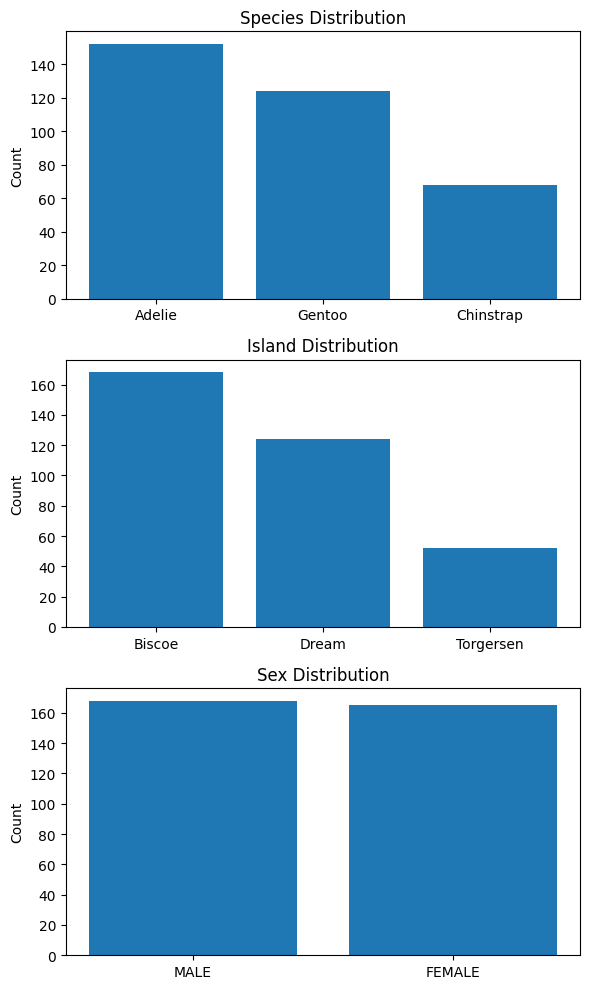

In [11]:
# Lets visualize the distribution of categorical features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(6, 10))

axes[0].bar(species_distribution.index, species_distribution.values)
axes[0].set_title("Species Distribution")
axes[0].set_ylabel("Count")

axes[1].bar(island_distribution.index, island_distribution.values)
axes[1].set_title("Island Distribution")
axes[1].set_ylabel("Count")

axes[2].bar(sex_distribution.index, sex_distribution.values)
axes[2].set_title("Sex Distribution")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


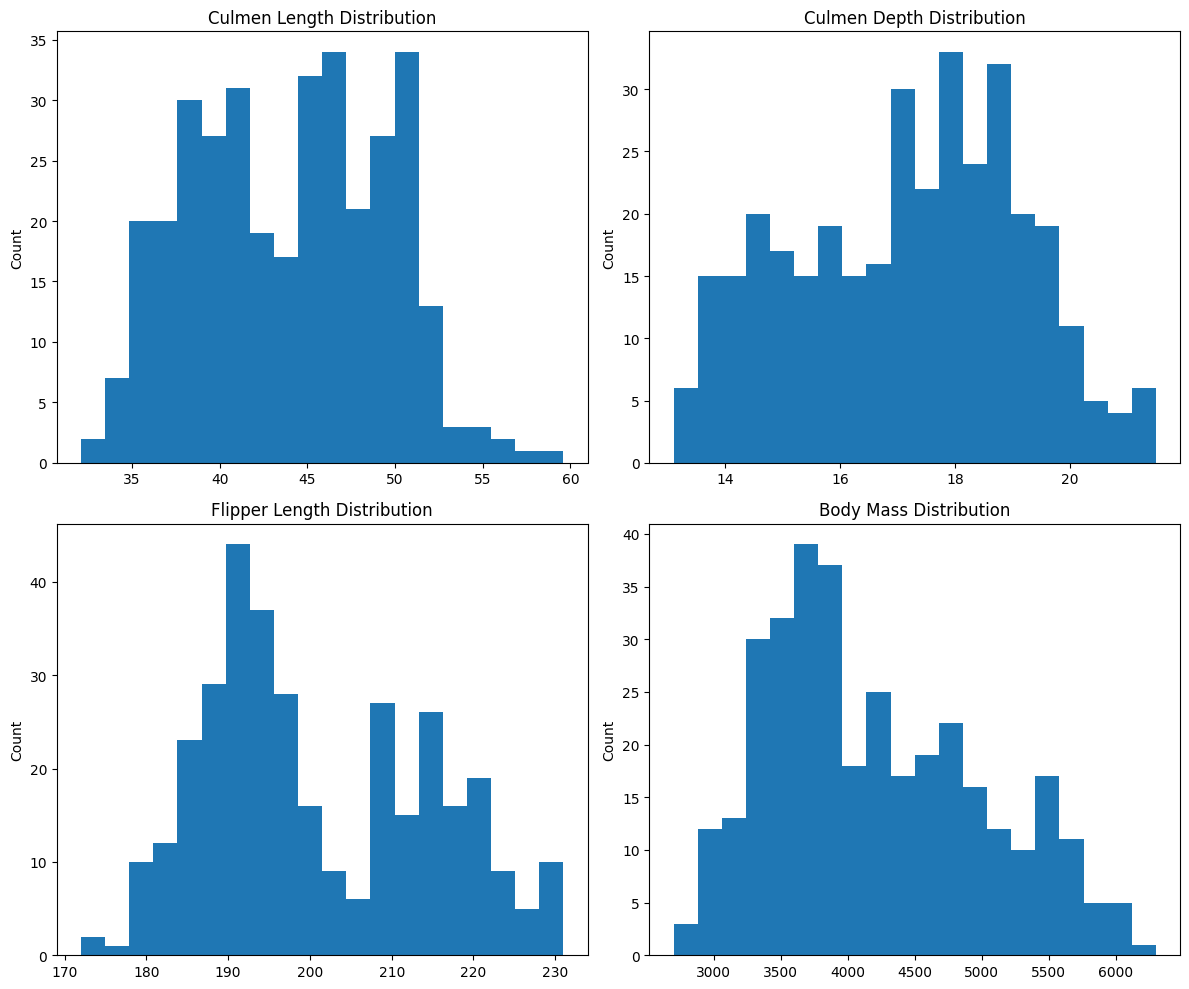

In [12]:
# Let's visualize the distribution of numerical features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axes[0, 0].set_title("Culmen Length Distribution")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axes[0, 1].set_title("Culmen Depth Distribution")
axes[0, 1].set_ylabel("Count")

axes[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axes[1, 0].set_title("Flipper Length Distribution")
axes[1, 0].set_ylabel("Count")

axes[1, 1].hist(penguins["body_mass_g"], bins=20)
axes[1, 1].set_title("Body Mass Distribution")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


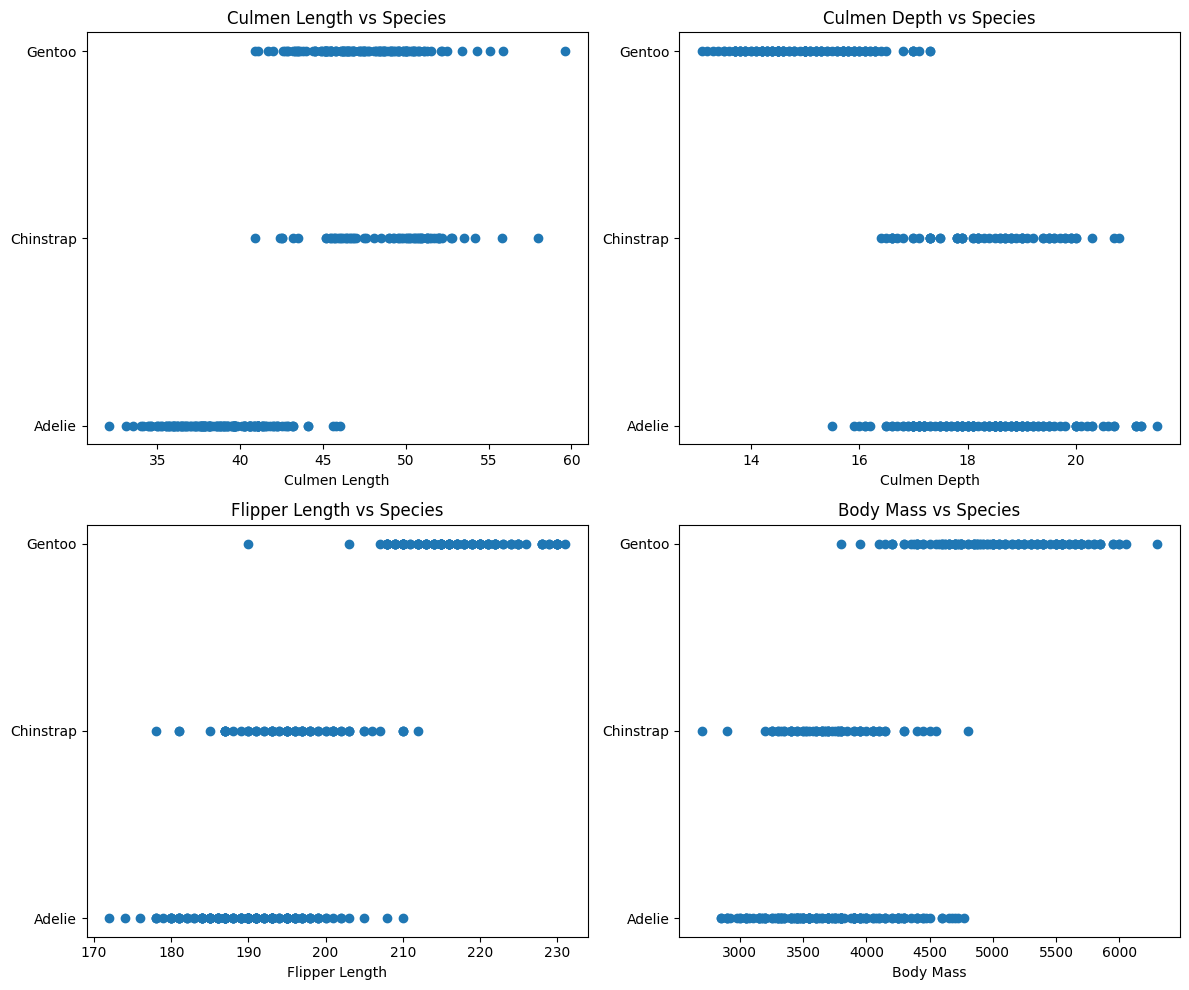

In [13]:
# Let's visualize the relationship between the numerical features and the target
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(penguins["culmen_length_mm"], penguins["species"])
axes[0, 0].set_title("Culmen Length vs Species")
axes[0, 0].set_xlabel("Culmen Length")

axes[0, 1].scatter(penguins["culmen_depth_mm"], penguins["species"])
axes[0, 1].set_title("Culmen Depth vs Species")
axes[0, 1].set_xlabel("Culmen Depth")

axes[1, 0].scatter(penguins["flipper_length_mm"], penguins["species"])
axes[1, 0].set_title("Flipper Length vs Species")
axes[1, 0].set_xlabel("Flipper Length")

axes[1, 1].scatter(penguins["body_mass_g"], penguins["species"])
axes[1, 1].set_title("Body Mass vs Species")
axes[1, 1].set_xlabel("Body Mass")

plt.tight_layout()
plt.show()


Let’s display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are
associated with changes in a seconf variable.
In other words, the covariance measures the degree to which two variables change together.


In [14]:
penguins.cov(numeric_only=True)


Empty DataFrame
Columns: []
Index: []

Here are three examples of what we get from interpreting the covariance matrix below:

1. The positive covariance of 50.26 between culmen length and flippler length suggests that larger values of culmen length are associated with larger values of flipper length. As one increases, generally so does the other.
2. The positive covariance of 2596.97 between culmen length and body mass suggests that heavier penguins generally have longer culmens. There is a tendency for these two variables to increase together.
3. The negative covariance of -742.66 between culmen depth and body mass suggests a general tendency that penguins with deeper culmens weigh less.


Let’s display the correlation matrix of the dataset. The "correlation" measures the strength and direction of a linear relationship between two variables.


In [15]:
penguins.corr(numeric_only=True)


Empty DataFrame
Columns: []
Index: []

Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have longer flippers.
2. Penguins with a shallower culmen tend to have longer flippers.
3. Penguins with longer culmens tend to have longer flippers.


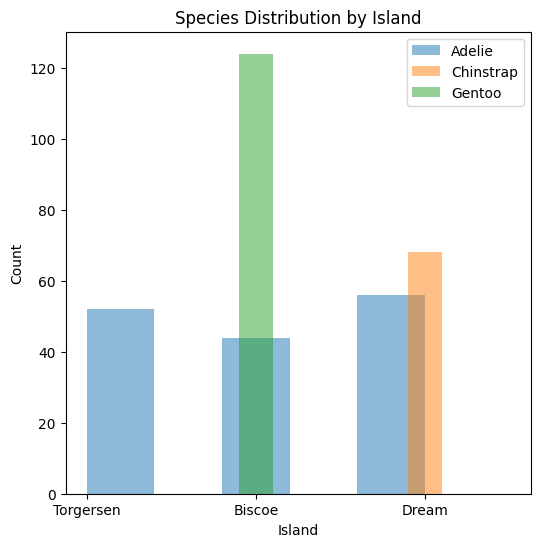

In [16]:
# lets display the distributino of species by island
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_title("Species Distribution by Island")
ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.legend()
plt.show()


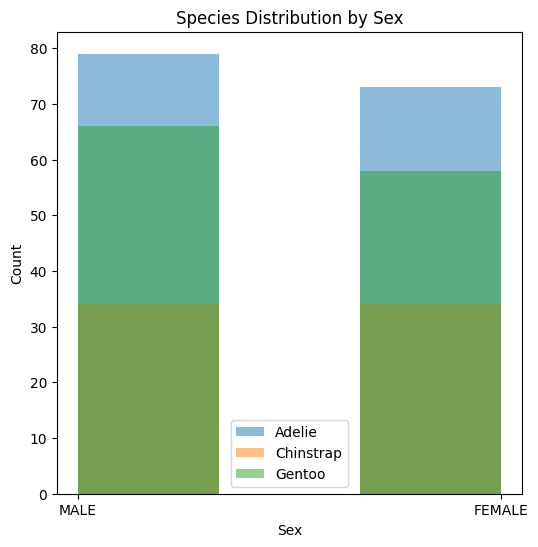

In [17]:
# distribution of species by sex
fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_title("Species Distribution by Sex")
ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.legend()
plt.show()


## Section 3: Splitting and Transforming the Data

In this session we'll build a simple
[Azure ML Pipeline](https://learn.microsoft.com/en-us/azure/machine-learning/concept-ml-pipelines?view=azureml-api-2)
with one step to split and transform the data:

<a href="images/processing-step.png" target="_blank"> <img src="images/processing-step.png" alt="High-level overview 
of the Preprocessing Step" style="max-width: 740px;" /></a>

TODO: update the paragraph below with Azure specific details and links

We'll use a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor]
(https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to
execute a preprocessing script.
Check the [Azure ML Pipeline Overview](https://learn.microsoft.com/en-us/azure/machine-learning/concept-component?view=azureml-api-2) for an introduction to the fundamental
components of a Azure ML Pipeline.


### Step 1: Creating the Preprocessing Script

~~The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon
.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and
transform the data.~~

~~This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output
to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data
validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.~~

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipeline-python?view=azureml-api-2

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-inputs-outputs-pipeline?view=azureml-api-2

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-pipeline-component?view=azureml-api-2

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-use-parallel-job-in-pipeline?view=azureml-api-2


In [18]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])


In [19]:
%%writefile {CODE_FOLDER}/processing/script_azure.py
# | filename: script.py
# | code-line-numbers: true

import tempfile
import joblib
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
        base_directory,
        X_train,  # noqa: N803
        y_train,
        X_validation,  # noqa: N803
        y_validation,
        X_test,  # noqa: N803
        y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory='/opt/ml/processing')


Overwriting code/processing/script_azure.py


In [20]:
%%ipytest -s
# | code-fold: true

import pytest
import os


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_directory=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"


EEEEEEEE
============================================= ERRORS ==============================================
_____________________ ERROR at setup of test_preprocess_generates_data_splits _____________________

    @pytest.fixture(autouse=False)
    def directory():
>       directory = tempfile.mkdtemp()
E       NameError: name 'tempfile' is not defined

C:\Users\ayush\AppData\Local\Temp\ipykernel_41668\302004885.py:9: NameError
______________________ ERROR at setup of test_preprocess_generates_baselines ______________________

    @pytest.fixture(autouse=False)
    def directory():
>       directory = tempfile.mkdtemp()
E       NameError: name 'tempfile' is not defined

C:\Users\ayush\AppData\Local\Temp\ipykernel_41668\302004885.py:9: NameError
______________________ ERROR at setup of test_preprocess_creates_two_models _______________________

    @pytest.fixture(autouse=False)
    def directory():
>       directory = tempfile.mkdtemp()
E       NameError: name 'tempfile' is not defined

Error: ipytest failed with exit_code 1

In [12]:
DEPENDENCY_DIR = Path("../container")
sys.path.extend([f"/{DEPENDENCY_DIR}"])
Path(DEPENDENCY_DIR).mkdir(parents=True, exist_ok=True)


In [7]:
from azure.ai.ml.entities import Environment

custom_env_name = "mlschool"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for penguins pipeline",
    conda_file=os.path.join(DEPENDENCY_DIR, "ml-dependencies.yml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    version="0.1.2",
)
pipeline_job_env = client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}",
)


Environment with name mlschool is registered to workspace, the environment version is 0.1.2


In [8]:
data_asset = client.data.get("penguins", version="2")
data_asset


Data({'path': 'azureml://subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourcegroups/ml-school-rg/workspaces/ml-school/datastores/workspaceblobstore/paths/UI/2024-04-08_162623_UTC/penguins.csv', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'penguins', 'description': 'penguins dataset in csv format from ml_school repo', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/data/penguins/versions/2', 'Resource__source_path': '', 'base_path': '/Users/ayushgupta/Dev/DataspellProjects/ml.school/program', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x107caab10>, 'serialize': <msrest.serialization.Serializer object at 0x15e7dfcd0>, 'version': '2', 'latest_versio

In [9]:
data_store = client.datastores.get_default()
data_store


AzureBlobDatastore({'type': <DatastoreType.AZURE_BLOB: 'AzureBlob'>, 'name': 'workspaceblobstore', 'description': None, 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/datastores/workspaceblobstore', 'Resource__source_path': '', 'base_path': '/Users/ayushgupta/Dev/DataspellProjects/ml.school/program', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x15e1a4ed0>, 'credentials': {'type': 'account_key'}, 'container_name': 'azureml-blobstore-281c01c8-247f-4d8a-aadf-066659a08b99', 'account_name': 'mlschool8111413849', 'endpoint': 'core.windows.net', 'protocol': 'https'})

In [25]:
env = client.environments.get(name="mlschool", version="0.1.2")

env


Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': 'mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'mlschool', 'description': 'Custom environment for penguins pipeline', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/environments/mlschool/versions/0.1.2', 'Resource__source_path': '', 'base_path': 'D:\\DataspellProjects\\ml.school\\program', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000024E0CEBBC50>, 'serialize': <msrest.serialization.Serializer object at 0x0000024E0CE38590>, 'version': '0.1.2', 'conda_file': {'channels': ['defaults', 'conda-forge'], 'dependencies': ['python=3.11', 'numpy', 'pandas', 'sci

In [99]:
# %%writefile {CODE_FOLDER}/processing/move_data.py
#
# import shutil
# import argparse
#
#
# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--source', type=str)
#     parser.add_argument('--destination', type=str)
#     args = parser.parse_args()
#
#     shutil.copy(src=args.source, dst=args.destination)
#
#
# if __name__ == "__main__":
#     main()


Overwriting code/processing/move_data.py


In [10]:
output_path = (
    "azureml://datastores/workspaceblobstore/paths/opt/processing/input/penguins.csv"
)


In [11]:
from azure.ai.ml import Input, Output, command
from azure.ai.ml.constants import AssetTypes, InputOutputModes

move_file_component = command(
    name="move_file",
    inputs={
        "src": Input(
            path=data_asset.path,
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RO_MOUNT,
        ),
    },
    outputs={
        "dest": Output(
            path=output_path,
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
    },
    environment=f"{pipeline_job_env.name}:{pipeline_job_env.version}",
    code="./code/processing/move_data.py",
    command="python move_data.py --source ${{inputs.src}} --destination ${{outputs.dest}}",
    compute="serverless",
)


In [163]:
# https://learn.microsoft.com/en-us/azure/machine-learning/how-to-read-write-data-v2?view=azureml-api-2&tabs=python

from azure.ai.ml import Input, Output, command
from azure.ai.ml.constants import AssetTypes, InputOutputModes

# ==============================================================
# Set the input and output URI paths for the data. Supported paths include:
# local: `./<path>
# Blob: wasbs://<container_name>@<account_name>.blob.core.windows.net/<path>
# ADLS: abfss://<file_system>@<account_name>.dfs.core.windows.net/<path>
# Datastore: azureml://datastores/<data_store_name>/paths/<path>
# Data Asset: azureml:<my_data>:<version>
# As an example, we set the input path to a file on a public blob container
# As an example, we set the output path to a folder in the default datastore
# ==============================================================
input_path = data_asset.id
# when defining output path, you can use your own path but it has to come after the datastores/workspaceblobstore/paths/ prefix
output_path = (
    "azureml://datastores/workspaceblobstore/paths/opt/processing/input/penguins.csv"
)

# ==============================================================
# What type of data are you pointing to?
# AssetTypes.URI_FILE (a specific file)
# AssetTypes.URI_FOLDER (a folder)
# AssetTypes.MLTABLE (a table)
# The path we set above is a specific file
# ==============================================================
data_type = AssetTypes.URI_FILE

# ==============================================================
# Set the input mode. The most commonly-used modes:
# InputOutputModes.RO_MOUNT
# InputOutputModes.DOWNLOAD
# Set the mode to Read Only (RO) to mount the data
# ==============================================================
input_mode = InputOutputModes.RO_MOUNT

# ==============================================================
# Set the output mode. The most commonly-used modes:
# InputOutputModes.RW_MOUNT
# InputOutputModes.UPLOAD
# Set the mode to Read Write (RW) to mount the data
# ==============================================================
output_mode = InputOutputModes.RW_MOUNT

# Set the input and output for the job:
inputs = {"input_data": Input(type=data_type, path=input_path, mode=input_mode)}

outputs = {
    "output_data": Output(
        type=data_type,
        path=output_path,
        mode=output_mode,
        # optional: if you want to create a data asset from the output,
        # then uncomment name (name can be set without setting version)
        # name = "<name_of_data_asset>",
        # version = "<version>",
    ),
}

# This command job copies the data to your default Datastore
copy_job = command(
    name="copy_data",
    description="Copy data from one location to another",
    command="cp ${{inputs.input_data}} ${{outputs.output_data}}",
    inputs=inputs,
    outputs=outputs,
    environment=f"{pipeline_job_env.name}:{pipeline_job_env.version}",
    # compute="serverless",
)

# Submit the command
client.jobs.create_or_update(copy_job)


Command({'parameters': {}, 'init': False, 'name': 'copy_data', 'type': 'command', 'status': 'Completed', 'log_files': None, 'description': 'Copy data from one location to another', 'tags': {}, 'properties': {'mlflow.source.git.repoURL': 'https://github.com/agpt8/ml.school.git', 'mlflow.source.git.branch': 'azure', 'mlflow.source.git.commit': '2791884f5593985eef751c29e4f2b1cb6fe69007', 'azureml.git.dirty': 'True', '_azureml.ComputeTargetType': 'amlctrain', '_azureml.ClusterName': None, 'ProcessInfoFile': 'azureml-logs/process_info.json', 'ProcessStatusFile': 'azureml-logs/process_status.json', 'StartTimeUtc': '2024-04-17 14:37:30', 'EndTimeUtc': '2024-04-17 14:39:40'}, 'print_as_yaml': False, 'id': '/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/jobs/copy_data', 'Resource__source_path': '', 'base_path': 'D:\\DataspellProjects\\ml.school\\program', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000024E0CF40510>, 'serialize': <msrest.serialization.Serializer object at 0x0000024E14DB28D0>, 'allowed_keys': {}, 'key_restriction': False, 'logger': <TraceLogger attr_dict (WARNING)>, 'display_name': 'copy_data', 'experiment_name': 'program', 'compute': None, 'services': {'Tracking': {'endpoint': 'azureml://centralindia.api.azureml.ms/mlflow/v1.0/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school?', 'type': 'Tracking'}, 'Studio': {'endpoint': 'https://ml.azure.com/runs/copy_data?wsid=/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourcegroups/ml-school-rg/workspaces/ml-school&tid=68732935-15d4-4080-89bd-fbbe467d308b', 'type': 'Studio'}}, 'comment': None, 'job_inputs': {'input_data': {'type': 'uri_file', 'path': 'azureml://subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourcegroups/ml-school-rg/workspaces/ml-school/datastores/workspaceblobstore/paths/UI/2024-04-08_162623_UTC/penguins.csv', 'mode': 'ro_mount'}}, 'job_outputs': {'output_data': {'type': 'uri_file', 'path': 'azureml://datastores/workspaceblobstore/paths/opt/processing/input/penguins.csv', 'mode': 'rw_mount'}, 'default': {'type': 'uri_folder', 'path': 'azureml://datastores/workspaceartifactstore/ExperimentRun/dcid.copy_data', 'mode': 'rw_mount'}}, 'inputs': {'input_data': <azure.ai.ml.entities._job.pipeline._io.base.NodeInput object at 0x0000024E14DB1110>}, 'outputs': {'output_data': <azure.ai.ml.entities._job.pipeline._io.base.NodeOutput object at 0x0000024E14F83E50>, 'default': <azure.ai.ml.entities._job.pipeline._io.base.NodeOutput object at 0x0000024E14F83950>}, 'component': CommandComponent({'latest_version': None, 'intellectual_property': None, 'auto_increment_version': True, 'source': 'REMOTE.WORKSPACE.JOB', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'copy_data', 'description': 'Copy data from one location to another', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': None, 'Resource__source_path': None, 'base_path': 'D:\\DataspellProjects\\ml.school\\program', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000024E0CF40510>, 'serialize': <msrest.serialization.Serializer object at 0x0000024E150BBF50>, 'command': 'cp ${{inputs.input_data}} ${{outputs.output_data}}', 'code': None, 'environment_variables': {}, 'environment': '/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/environments/mlschool/versions/0.1.2', 'distribution': None, 'resources': None, 'queue_settings': None, 'version': None, 'schema': None, 'type': 'command', 'display_name': 'copy_data', 'is_deterministic': True, 'inputs': {'input_data': {'type': 'uri_file', 'path': 'azureml://subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourcegroups/ml-school-rg/workspaces/ml-school/datastores/workspaceblobstore/paths/UI/2024-04-

In [159]:
from azure.ai.ml import Input, command
from azure.ai.ml.constants import AssetTypes, InputOutputModes

data_asset = client.data.get("penguins", version="2")

# to successfully create a job, customize the parameters below based on your workspace resources
job = command(
    command='ls "${{inputs.data}}"',
    inputs={
        "data": Input(
            path=data_asset.id,
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RO_MOUNT,
        ),
    },
    environment="azureml:AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
)
returned_job = client.jobs.create_or_update(job)


In [138]:
from azure.ai.ml.dsl import pipeline


@pipeline()
def move_data_pipeline(source: str):
    move_data_step = move_file_component(src=source)
    print(move_data_step)
    return {"dest": move_data_step.outputs.dest}


In [139]:
# Define the source and destination paths
source_path = data_asset
destination_path = f"{data_store}/opt/processing/input/"

# Create the pipeline
pipeline = move_data_pipeline(source=source_path, destination=destination_path)

# Submit the pipeline run
pipeline_run = client.jobs.create_or_update(
    pipeline,
    experiment_name="move_data_experiment",
)

# Stream the logs
client.jobs.stream(pipeline_run.name)


type: command
inputs:
  src:
    path: ${{parent.inputs.source}}
outputs:
  dest:
    mode: rw_mount
    type: uri_file
    path: azureml://datastores/workspaceblobstore/opt/processing/input/penguins.csv
environment: azureml:mlschool:0.1.2
component:
  name: move_file
  type: command
  inputs:
    src:
      type: uri_file
      mode: ro_mount
  outputs:
    dest:
      type: uri_file
      mode: rw_mount
  command: python move_data.py --source ${{inputs.src}} --destination ${{outputs.dest}}
  environment: azureml:/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/environments/mlschool/versions/0.1.2
  code: azureml:/subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-rg/providers/Microsoft.MachineLearningServices/workspaces/ml-school/codes/15d53a36-2c62-441e-8a62-aae141260471/versions/1
  id: /subscriptions/2acef264-d285-40af-be00-8dae3516307c/resourceGroups/ml-school-

JobException: Exception : 
 {
    "error": {
        "code": "UserError",
        "message": "Pipeline has failed child jobs. Failed nodes: /move_data_step. For more details and logs, please go to the job detail page and check the child jobs.",
        "message_format": "Pipeline has failed child jobs. {0}",
        "message_parameters": {},
        "reference_code": "PipelineHasStepJobFailed",
        "details": []
    },
    "environment": "centralindia",
    "location": "centralindia",
    "time": "2024-04-17T11:27:53.692914Z",
    "component_name": ""
} 

In [ ]:
client.datastores.get_default()


In [ ]:
data_asset = client.data.get("penguins", version="2")

job = command(
    name="split-trasnform",
    description="Split and trasnform data",
    command="python script_azure.py",
    inputs={
        "data": Input(
            path=data_asset.path,
            type="uri_file",
        ),
    },
    output={
        "train": Output(
            path="/opt/ml/processing/train",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
        "validation": Output(
            path="/opt/ml/processing/validation",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
        "test": Output(
            path="/opt/ml/processing/test",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
        "train_baseline": Output(
            path="/opt/ml/processing/train-baseline",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
        "test_baseline": Output(
            path="/opt/ml/processing/test-baseline",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
        "model": Output(
            path="/opt/ml/processing/model",
            type=AssetTypes.URI_FILE,
            mode=InputOutputModes.RW_MOUNT,
        ),
    },
    environment=env,
    code=f"{(CODE_FOLDER / 'processing' / 'script_azure.py').as_posix()}",
    version="0.1.2",
)

returned_job = client.jobs.create_or_update(job)
